In [1]:
import warnings
warnings.filterwarnings('ignore')
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y,random_state=1)

## Combining transformers and estimators in a pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


## Using k-fold cross-validation to assess model performance

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
#kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
kfold = StratifiedKFold(n_splits=10).split(X_train,y_train)
scores = []

In [10]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [11]:
print('\nCV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [13]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.950 +/- 0.014


## Diagnosing bias and variance problems with learning curves

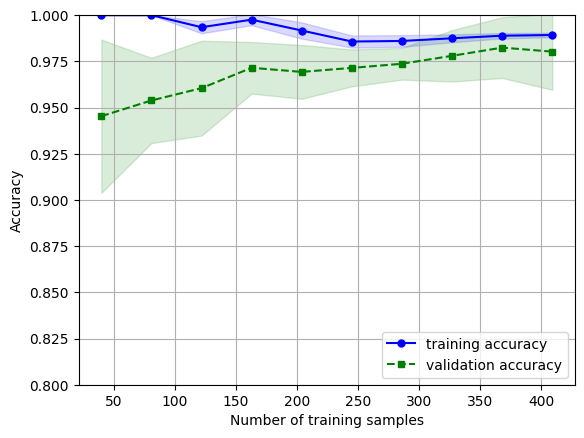

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
LogisticRegression(penalty='l2',random_state=1))
train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),cv=10,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

## Addressing Overfitting and Underfitting with Validation curves

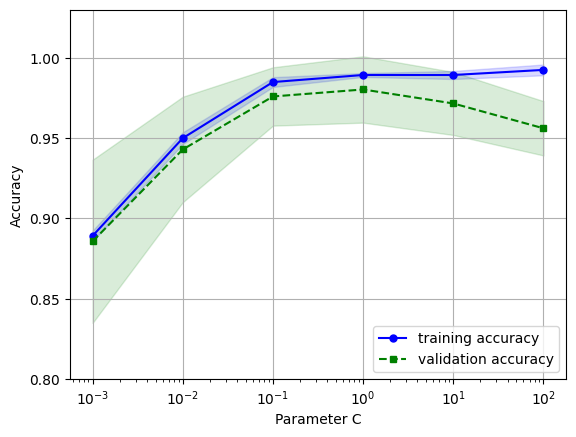

In [15]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,X=X_train,y=y_train,param_name='logisticregression__C',param_range=param_range,cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,train_mean - train_std, alpha=0.15,color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

## Fine-tuning machine learning models via grid search

## Tuning hyperparameters via grid search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},{'svc__C': param_range,'svc__gamma': param_range,'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [16]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


In [17]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=2)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [18]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
param_grid=[{'max_depth': [1, 2, 3,4, 5, 6, 7, None]}],scoring='accuracy',cv=2)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.934 +/- 0.016


## Looking at different performance evaluation metrics

### Reading a confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


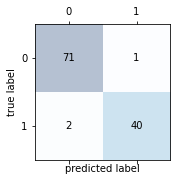

In [20]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,s=confmat[i, j],va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## Optimizing the Precision and Recall of a Classification Model

In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [22]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## Plotting a receiver operating characteristic

C:\Users\ankit19.gupta\Desktop\Self_Projects\Python_Machine_Learning_Sebastian_Raschka\venv_python_3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankit19.gupta\Desktop\Self_Projects\Python_Machine_Learning_Sebastian_Raschka\venv_python_3.6\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]
C:\Users\ankit19.gupta\Desktop\Self_Projects\Python_Machine_Learning_Sebastian_Raschka\venv_python_3.6\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankit19.gupta\Desktop\Self_Projects\Python_Machine_Learning_Sebastian_Raschka\venv_python_3.6\lib\site-packages\ipykernel_launcher.py:13: DeprecationW

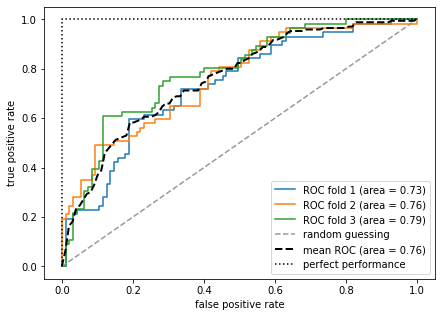

In [53]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2',random_state=1,C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3,random_state=1).split(X_train,y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC fold %d (area = %0.2f)'% (i+1, roc_auc))
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],[0, 1, 1],linestyle=':',color='black',label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.show()

## Scoring Metrics for multiclass classification

In [54]:
pre_scorer = make_scorer(score_func=precision_score,pos_label=1,greater_is_better=True,average='micro')

In [55]:
pre_scorer

make_scorer(precision_score, pos_label=1, average=micro)

## Dealing with class imbalance

In [56]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [57]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [58]:
from sklearn.utils import resample
print('Number of class 1 samples before:',X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],y_imb[y_imb == 1],replace=True,n_samples=X_imb[y_imb == 0].shape[0],random_state=123)
print('Number of class 1 samples after:',X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [59]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [60]:
y_pred = np.zeros(y_bal.shape[0])
>>> np.mean(y_pred == y_bal) * 100

50.0